In [159]:
 #Import All Libraries Here
import pandas as pd
from sklearn.metrics import accuracy_score ,  roc_curve, auc , classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
import xgboost as xgb 
import statistics
from scipy.fftpack import fft, ifft


from imblearn.over_sampling import SMOTE 

In [160]:
# Record Constants
INPUT_TRAIN_IN = "../data/train_in.csv"
INPUT_TRAIN_OUT = "../data/train_out.csv"  
INPUT_TEST_IN = "../data/test_in.csv"
INPUT_TEST_OUT = "../data/test_out.csv"

WINDOW_SIZE =  25 # Final RNA Sequence will be 101 Length 
MAX_LENGTH = (WINDOW_SIZE * 2)+1
ENCODING_METHOD = 1 # 1 - Non Furiour Transformation , 2  -  Fourier Transformation 

In [161]:
#Read X Varaibles and Y Varaibles

x_train_raw =  pd.read_csv(INPUT_TRAIN_IN, header=None , skiprows=1 )
y_train_raw =  pd.read_csv(INPUT_TRAIN_OUT, header=None , skiprows=1 )

x_test_raw =  pd.read_csv(INPUT_TEST_IN, header=None , skiprows=1)
y_test_raw =  pd.read_csv(INPUT_TEST_OUT, header=None , skiprows=1)

In [162]:
# Apply ANF Encoding on Input Features
def apply_accumulated_nucle_frequency(seq):
    mapping = []
    A = 0
    C = 0
    T = 0
    G = 0
    for i, v in seq.items():
        if v == 'A':
            A += 1
            mapping.append(A / (i + 1))
        elif v == 'C':
            C += 1
            mapping.append(C / (i + 1))
        elif v == 'T' or v == 'U':
            T += 1
            mapping.append(T / (i + 1))
        else:
            G += 1
            mapping.append(G / (i + 1))
    padding = (MAX_LENGTH - len(mapping))
    mapping = np.pad(mapping, (0, padding), 'constant')
    return mapping

In [163]:
# Encode X Features Based on Middle Index
def encode_x(x_train_raw):
    middle_index = (x_train_raw.shape[1] // 2) + 1
    truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
    result = truncated_df.apply(apply_accumulated_nucle_frequency, axis=1)
    return result 

x_train_encoded = encode_x(x_train_raw)

In [164]:
# # Reshape Y Cateory 
def reshape_y(row):
    result = []
    for r in row :
        result.append(int(r))
    return np.array(result)


def encode_y(input):
    y_train_encode = input.apply(reshape_y , axis=1)
    return y_train_encode

y_train_encode = encode_y(y_train_raw)


In [165]:
x_train= x_train_encoded.tolist()
y_train = y_train_encode.tolist()

#print("Shape of X Train : " , x_train.shape , " Shape of Y Train : " , y_train.shape)

clf = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1, max_depth=4 , objective='multi:softmax' , num_class = 12))
clf.fit(x_train , y_train )

In [ ]:

x_test = encode_x(x_test_raw).tolist()
y_test = encode_y(y_test_raw).tolist()

y_pred = clf.predict(x_test)

# Calculate the accuracy score of the xgboost regression model
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

Accuracy of XGBoost  model: 0.49


Accuracy of XGBoost  model: 0.49


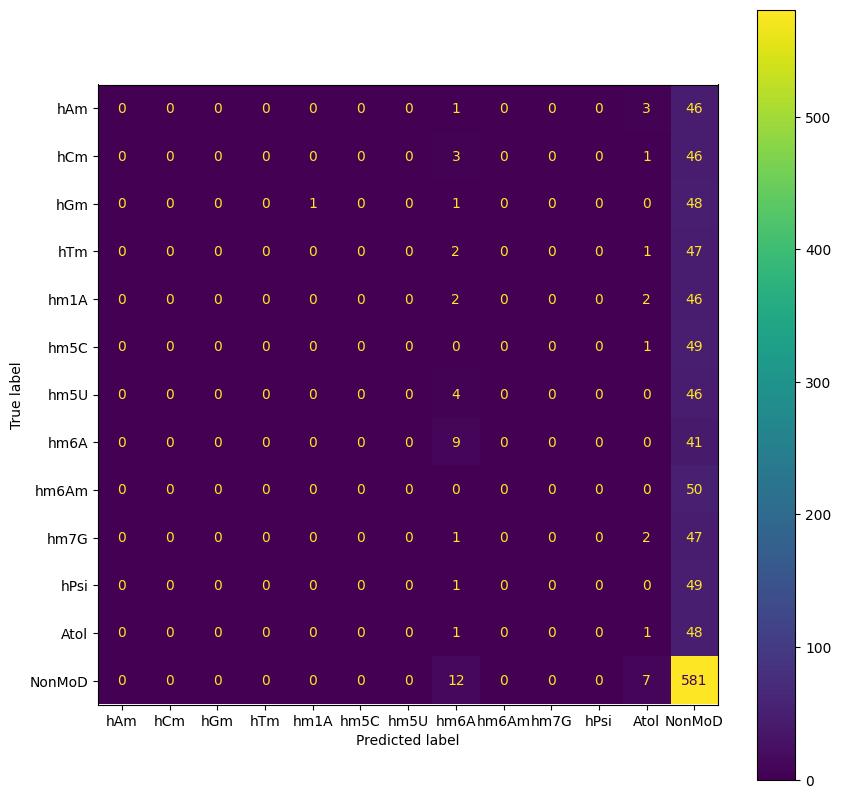

In [ ]:
RMs = ['hAm','hCm','hGm','hTm','hm1A','hm5C','hm5U','hm6A','hm6Am','hm7G','hPsi','Atol','NonMoD']

def decode_y(row):   
    decoded = ''
    for index , n in enumerate(row) :
        if n == 1 :
            decoded = RMs[index]
    
    if decoded == '':
        return 'NonMoD'
    
    return decoded 


y_test_decoded = []
for y in y_test:
    y_test_decoded.append(decode_y(y))

y_predicted_decoded = []
for a in y_pred:
    y_predicted_decoded.append(decode_y(a))


# Plot confusion matrix 
cm = confusion_matrix(y_test_decoded, y_predicted_decoded, labels=np.array(RMs))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=np.array(RMs))

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

#  ---------------------- Further Feature Extraction with ANF Fourier Transform -----------------------------------

In [ ]:
def feature_extraction(features, spectrum, spectrumTwo):
    average = sum(spectrum) / len(spectrum)
    features.append(average)
    ###################################
    median = np.median(spectrum)
    features.append(median)
    ###################################
    maximum = np.max(spectrum)
    features.append(maximum)
    ###################################
    minimum = np.min(spectrum)
    features.append(minimum)
    ###################################
    peak = (len(spectrum) / 3) / (average)
    features.append(peak)
    ###################################
    peak_two = (len(spectrumTwo) / 3) / (np.mean(spectrumTwo))
    features.append(peak_two)
    ###################################
    standard_deviation = np.std(spectrum)  # standard deviation
    features.append(standard_deviation)
    ###################################
    standard_deviation_pop = statistics.stdev(spectrum)  # population sample standard deviation
    features.append(standard_deviation_pop)
    ###################################
    percentile15 = np.percentile(spectrum, 15)
    features.append(percentile15)
    ###################################
    percentile25 = np.percentile(spectrum, 25)
    features.append(percentile25)
    ###################################
    percentile50 = np.percentile(spectrum, 50)
    features.append(percentile50)
    ###################################
    percentile75 = np.percentile(spectrum, 75)
    features.append(percentile75)
    ###################################
    amplitude = maximum - minimum
    features.append(amplitude)
    ###################################
    # mode = statistics.mode(spectrum)
    ###################################
    variance = statistics.variance(spectrum)
    features.append(variance)
    ###################################
    interquartile_range = np.percentile(spectrum, 75) - np.percentile(spectrum, 25)
    features.append(interquartile_range)
    ###################################
    semi_interquartile_range = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / 2
    features.append(semi_interquartile_range)
    ###################################
    coefficient_of_variation = standard_deviation / average
    features.append(coefficient_of_variation)
    ###################################
    skewness = (3 * (average - median)) / standard_deviation
    features.append(skewness)
    ###################################
    kurtosis = (np.percentile(spectrum, 75) - np.percentile(spectrum, 25)) / (
            2 * (np.percentile(spectrum, 90) - np.percentile(spectrum, 10)))
    features.append(kurtosis)
    ###################################
    return

def accumulated_nucle_frequency_fourier(seq):
    mapping = []
    spectrumTwo = []
    spectrum = []
    features = []
    A = 0
    C = 0
    T = 0
    G = 0
    
    for i , v in seq.items():
        if v == 'A':
            A += 1
            mapping.append(A / (i + 1))
        elif v == 'C':
            C += 1
            mapping.append(C / (i + 1))
        elif v == 'T' or seq[i] == 'U':
            T += 1
            mapping.append(T / (i + 1))
        else:
            G += 1
            mapping.append(G / (i + 1))
            
    Fmap = fft(mapping)
    for i in range(len(mapping)):
        specTotal = (abs(Fmap[i]) ** 2)
        specTwo = (abs(Fmap[i]))
        spectrum.append(specTotal)
        spectrumTwo.append(specTwo)
    feature_extraction(features, spectrum, spectrumTwo)
    return features


In [ ]:
# Encode with Fourier Transform 
def encode_x_with_fourier(x_train_raw):
    middle_index = (x_train_raw.shape[1] // 2) + 1
    truncated_df = x_train_raw.iloc[:, middle_index - WINDOW_SIZE - 1: middle_index + WINDOW_SIZE]
    result = truncated_df.apply(accumulated_nucle_frequency_fourier, axis=1)
    return result 

x_train_encoded_fourier = encode_x_with_fourier(x_train_raw)

print(x_train_encoded_fourier.shape)

(10000,)


In [ ]:
# Train Model Again 

x_train_f= x_train_encoded_fourier.tolist()
y_train_f = y_train_encode.tolist()

#print("Shape of X Train : " , x_train.shape , " Shape of Y Train : " , y_train.shape)

clf_fourier = OneVsRestClassifier(xgb.XGBClassifier(n_jobs=-1, max_depth=4 , objective='multi:softmax' , num_class = 12))
clf_fourier.fit(x_train_f , y_train_f )


c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 4 is present in all training examples.
  warnings.warn(
c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 5 is present in all training examples.
  warnings.warn(
c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  warnings.warn(
c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 7 is present in all training examples.
  warnings.warn(
c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\multiclass.py:77: UserWarning: Label not 9 is present in all training examples.
  warnings.warn(
c:\Users\shashi.vish\Documents\Python Environment\RNA_ModX\lib\site-packages\sklearn\multi

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_class=12,
                                            num_parallel_tree=None,
                                            objective='multi:softmax', ...))

In [ ]:
# Predict Accuracy

x_test_f = encode_x_with_fourier(x_test_raw).tolist()
y_test_f = encode_y(y_test_raw).tolist()

y_pred_f = clf_fourier.predict(x_test_f)

# Calculate the accuracy score of the xgboost regression model
accuracy = accuracy_score(y_test_f, y_pred_f)

print("Accuracy of XGBoost  model: {:.2f}".format(accuracy))

Accuracy of XGBoost  model: 0.47
